In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import os
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [39]:
df = pd.read_csv('../input/DDD.csv')

In [40]:
df.head()

,Number_pregnant,Glucose_concentration,Blood_pressure,Triceps,Insulin,BMI,Pedigree,Age,Class,Group
0,6,0.743719,0.590164,0.353535,0.000000,0.500745,0.234415,50,1,B
1,1,0.427136,0.540984,0.292929,0.000000,0.396423,0.116567,31,0,C
2,8,0.919598,0.524590,0.000000,0.000000,0.347243,0.253629,32,1,B
3,1,0.447236,0.540984,0.232323,0.111111,0.418778,0.038002,21,0,B
4,0,0.688442,0.327869,0.353535,0.198582,0.642325,0.943638,33,1,C


In [41]:
df.columns

Index(['Number_pregnant', 'Glucose_concentration', 'Blood_pressure', 'Triceps',
       'Insulin', 'BMI', 'Pedigree', 'Age', 'Class', 'Group'],
      dtype='object')

**Visulization and Data Cleaning**

Text(0.5, 1.0, 'Age Count')

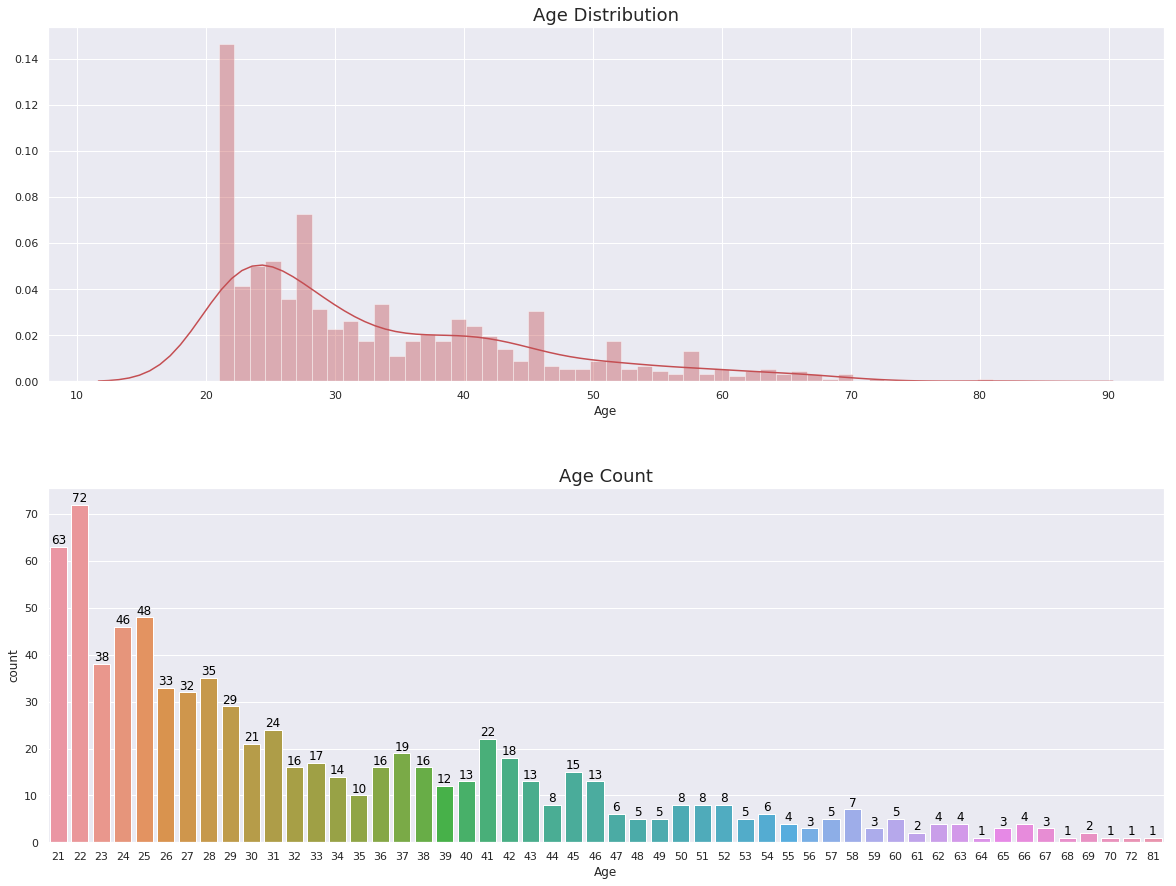

In [42]:
fig = plt.figure(figsize=(20,15))

sns.set()
plt.subplot(2, 1, 1)
sns.distplot(df['Age'], bins=50, color='r')
plt.title('Age Distribution', fontsize=18)

fig.subplots_adjust(hspace=.3)

plt.subplot(2, 1, 2)
ax = sns.countplot(df['Age'])
for p in ax.patches:
     ax.text(p.get_x() + p.get_width()/2., p.get_height(),  '%d' % int(p.get_height()),
            fontsize=12, color='black', ha='center', va='bottom')
plt.title('Age Count', fontsize=18)


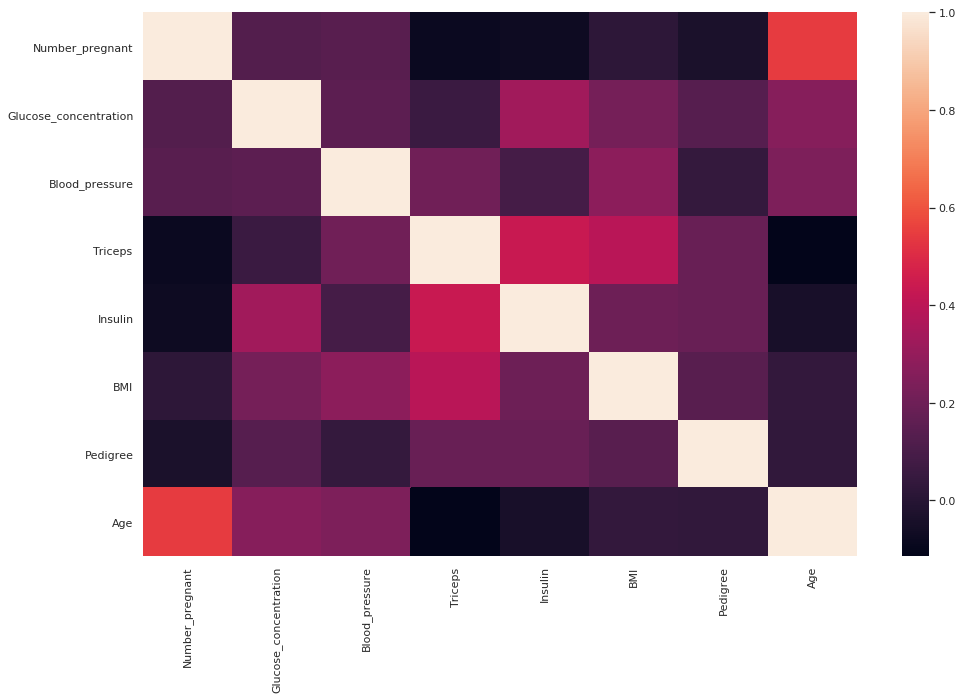

In [43]:
corr_df = df.iloc[:,:8]
plt.figure(figsize=(16,10))
sns.heatmap(corr_df.corr())

In [44]:
cols_to_norm = ['Number_pregnant', 'Glucose_concentration', 'Blood_pressure', 'Triceps',
       'Insulin', 'BMI', 'Pedigree']

In [45]:
df[cols_to_norm] = df[cols_to_norm].apply(lambda x: (x - x.min()) / (x.max() - x.min()))

In [46]:
df.head()

,Number_pregnant,Glucose_concentration,Blood_pressure,Triceps,Insulin,BMI,Pedigree,Age,Class,Group
0,0.352941,0.743719,0.590164,0.353535,0.000000,0.500745,0.234415,50,1,B
1,0.058824,0.427136,0.540984,0.292929,0.000000,0.396423,0.116567,31,0,C
2,0.470588,0.919598,0.524590,0.000000,0.000000,0.347243,0.253629,32,1,B
3,0.058824,0.447236,0.540984,0.232323,0.111111,0.418778,0.038002,21,0,B
4,0.000000,0.688442,0.327869,0.353535,0.198582,0.642325,0.943638,33,1,C


**Feature Columns**


In [47]:
df.columns

Index(['Number_pregnant', 'Glucose_concentration', 'Blood_pressure', 'Triceps',
       'Insulin', 'BMI', 'Pedigree', 'Age', 'Class', 'Group'],
      dtype='object')

In [48]:
import tensorflow as tf

**Continuous Features**
* Number of times pregnant
* Plasma glucose concentration a 2 hours in an oral glucose tolerance test
* Diastolic blood pressure (mm Hg)
* Triceps skin fold thickness (mm)
* 2-Hour serum insulin (mu U/ml)
* Body mass index (weight in kg/(height in m)^2)
* Diabetes pedigree function

In [49]:
num_preg = tf.feature_column.numeric_column('Number_pregnant')
plasma_gluc = tf.feature_column.numeric_column('Glucose_concentration')
dias_press = tf.feature_column.numeric_column('Blood_pressure')
tricep = tf.feature_column.numeric_column('Triceps')
insulin = tf.feature_column.numeric_column('Insulin')
bmi = tf.feature_column.numeric_column('BMI')
diabetes_pedigree = tf.feature_column.numeric_column('Pedigree')
age = tf.feature_column.numeric_column('Age')

**Categorical Features**

In [50]:
assigned_group = tf.feature_column.categorical_column_with_hash_bucket('Group', hash_bucket_size=10)
age_buckets = tf.feature_column.bucketized_column(age, boundaries=[20,30,40,50,60,70,80])
feat_cols = [num_preg ,plasma_gluc,dias_press ,tricep ,insulin,bmi,diabetes_pedigree ,assigned_group, age_buckets]

**Train test split and create model**

In [51]:
x_data = df.drop('Class',axis=1)
labels = df['Class']
X_train, X_test, y_train, y_test = train_test_split(x_data,labels,test_size=0.33, random_state=101)

In [52]:
input_func = tf.estimator.inputs.pandas_input_fn(x=X_train,y=y_train,batch_size=10,num_epochs=1000,shuffle=True)
model = tf.estimator.LinearClassifier(feature_columns=feat_cols,n_classes=2)
model.train(input_fn=input_func,steps=1000)

**Evaluation **

In [53]:
eval_input_func = tf.estimator.inputs.pandas_input_fn(
      x=X_test,
      y=y_test,
      batch_size=10,
      num_epochs=1,
      shuffle=False)

results = model.evaluate(eval_input_func)
results

{'accuracy': 0.71653545,
 'accuracy_baseline': 0.65748036,
 'auc': 0.7824352,
 'auc_precision_recall': 0.6164346,
 'average_loss': 0.5374329,
 'label/mean': 0.34251967,
 'loss': 5.250306,
 'precision': 0.5925926,
 'prediction/mean': 0.38335907,
 'recall': 0.55172414,
 'global_step': 1000}

**Predictions**

In [54]:
pred_input_func = tf.estimator.inputs.pandas_input_fn(
      x=X_test,
      batch_size=10,
      num_epochs=1,
      shuffle=False)

predictions = model.predict(pred_input_func)
list(predictions)

[{'logits': array([0.18937713], dtype=float32),
  'logistic': array([0.5472033], dtype=float32),
  'probabilities': array([0.4527967, 0.5472033], dtype=float32),
  'class_ids': array([1]),
  'classes': array([b'1'], dtype=object)},
 {'logits': array([0.5792627], dtype=float32),
  'logistic': array([0.6408977], dtype=float32),
  'probabilities': array([0.35910225, 0.64089775], dtype=float32),
  'class_ids': array([1]),
  'classes': array([b'1'], dtype=object)},
 {'logits': array([-0.3968613], dtype=float32),
  'logistic': array([0.40206668], dtype=float32),
  'probabilities': array([0.5979333 , 0.40206668], dtype=float32),
  'class_ids': array([0]),
  'classes': array([b'0'], dtype=object)},
 {'logits': array([-0.6689523], dtype=float32),
  'logistic': array([0.3387315], dtype=float32),
  'probabilities': array([0.66126853, 0.3387315 ], dtype=float32),
  'class_ids': array([0]),
  'classes': array([b'0'], dtype=object)},
 {'logits': array([-1.674365], dtype=float32),
  'logistic': array

**DNN Classifier**


In [55]:
dnn_model = tf.estimator.DNNClassifier(hidden_units=[10,10,10],feature_columns=feat_cols,n_classes=2)
embedded_group_column = tf.feature_column.embedding_column(assigned_group, dimension=4)

In [56]:
feat_cols = [num_preg ,plasma_gluc,dias_press ,tricep ,insulin,bmi,diabetes_pedigree ,embedded_group_column, age_buckets]
input_func = tf.estimator.inputs.pandas_input_fn(x=X_train,y=y_train,batch_size=10,num_epochs=1000,shuffle=True)
dnn_model = tf.estimator.DNNClassifier(hidden_units=[10,10,10],feature_columns=feat_cols,n_classes=2)

In [57]:
dnn_model.train(input_fn=input_func,steps=1000)

In [58]:
eval_input_func = tf.estimator.inputs.pandas_input_fn(
      x=X_test,
      y=y_test,
      batch_size=10,
      num_epochs=1,
      shuffle=False)

dnn_model.evaluate(eval_input_func)

{'accuracy': 0.71653545,
 'accuracy_baseline': 0.65748036,
 'auc': 0.7899029,
 'auc_precision_recall': 0.67180175,
 'average_loss': 0.54036033,
 'label/mean': 0.34251967,
 'loss': 5.278905,
 'precision': 0.5824176,
 'prediction/mean': 0.3790792,
 'recall': 0.6091954,
 'global_step': 1000}

**The Accuracy score using DNNClassifier is around 75%**